In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [19]:
base_dir = 'C:\\Users\\aaa\\DatasetLivrable1\\Livrable1'

In [29]:
img_height = 28
img_width = 28
batch_size = 32

In [30]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=  0.2,
  subset =  "both",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 41407 files belonging to 5 classes.
Using 33126 files for training.
Using 8281 files for validation.


In [31]:
# Create a Rescaling layer to ensure consistent dimensions
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [52]:
# Build a simple model to apply the Rescaling layer
model = tf.keras.Sequential([
    rescale,
    tf.keras.layers.Flatten()
])

In [53]:
# Extract features and labels
X_train, y_train = [], []
for images, labels in train_set:
    # Apply Rescaling and flatten the images
    flattened_images = model.predict(images)
    X_train.extend(flattened_images)
    y_train.extend(labels.numpy())

1/1 [==============================] - 0s 28ms/step


KeyboardInterrupt: 

In [54]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [55]:
# Convert y_train to a 1D array if needed
y_train = y_train.flatten()

In [56]:
# Create a base decision tree classifier
base_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)

In [57]:
# Create an AdaBoost classifier with the base classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)


In [58]:
# Train the AdaBoost classifier
adaboost_classifier.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   random_state=42)

In [59]:
# Extract features and labels from the test set
X_test, y_test = [], []
for images, labels in test_set:
    flattened_images = model.predict(images)
    X_test.extend(flattened_images)
    y_test.extend(labels.numpy())


1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: 

In [60]:
# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [61]:
# Convert y_test to a 1D array if needed
y_test = y_test.flatten()

In [62]:
# Evaluate the model on the test set
test_accuracy = adaboost_classifier.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 45.07%


In [63]:
# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

In [64]:
# Convert probabilities to binary predictions
binary_predictions = (y_pred > 0.5).astype(int)

In [65]:
# Calculate accuracy on the test set
test_accuracy_binary = accuracy_score(y_test, binary_predictions)
print(f'Test Accuracy (Binary): {test_accuracy_binary * 100:.2f}%')


Test Accuracy (Binary): 23.85%


In [66]:
# Function to show images with true and predicted labels
def show_sample_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(12, 4))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].reshape(img_height, img_width, 3))
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}', fontsize=10)
        plt.axis('off')

In [67]:
# Visualize a few predictions
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]
sample_predictions = binary_predictions[sample_indices]


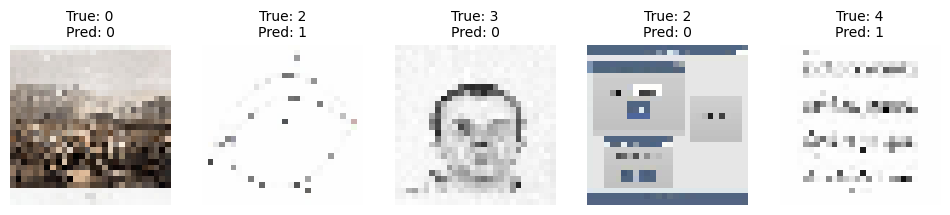

In [68]:
# Display the sample images
show_sample_images(sample_images, sample_labels, sample_predictions)
plt.show()